In [30]:
import os
import re
import pickle
import numpy as np
import chromadb
import plotly.graph_objects as go
from tqdm import tqdm
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from openai import OpenAI
from sklearn.manifold import TSNE
from testing import Tester

In [6]:
load_dotenv("../.env")

True

In [7]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

In [8]:
train[0].prompt

'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00'

In [10]:
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)

In [11]:
collection_name = "products"
existing_collection_names = [collection.name for collection in client.list_collections()]
if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection: {collection_name}")

collection = client.create_collection(collection_name)

In [12]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
model.encode(["Well hi there"])[0]

array([-9.46715921e-02,  4.27619480e-02,  5.51620498e-02, -5.10962738e-04,
        1.16203260e-02, -6.80130497e-02,  2.76405811e-02,  6.06974475e-02,
        2.88530309e-02, -1.74128171e-02, -4.94346656e-02,  2.30993368e-02,
       -1.28614372e-02, -4.31402922e-02,  2.17510257e-02,  4.26548645e-02,
        5.10499887e-02, -7.79727027e-02, -1.23247243e-01,  3.67455557e-02,
        4.54110606e-03,  9.47937742e-02, -5.53098507e-02,  1.70641206e-02,
       -2.92873308e-02, -4.47124951e-02,  2.06784457e-02,  6.39320165e-02,
        2.27427781e-02,  4.87789772e-02, -2.33503035e-03,  4.72859442e-02,
       -2.86258962e-02,  2.30624825e-02,  2.45130397e-02,  3.95681970e-02,
       -4.33176197e-02, -1.02316625e-01,  2.79874774e-03,  2.39304882e-02,
        1.61556154e-02, -8.99078418e-03,  2.07255688e-02,  6.40123338e-02,
        6.89179525e-02, -6.98360875e-02,  2.89764395e-03, -8.10988992e-02,
        1.71123203e-02,  2.50653620e-03, -1.06529057e-01, -4.87733148e-02,
       -1.67762041e-02, -

In [14]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [15]:
description(train[0])

'Delphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'

In [20]:
for i in tqdm(range(0, len(train), 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+1000)]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

100%|██████████| 400/400 [27:04<00:00,  4.06s/it]


### Visualize the embeddings

In [21]:
collection = client.get_or_create_collection('products')

In [22]:
MAXIMUM_DATAPOINTS = 10_000

CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories',
              'Electronics','Musical_Instruments', 'Office_Products',
              'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['red', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'cyan']

In [23]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [25]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [26]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

In [27]:
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

### RAG pipeline with GPT-4o-mini

In [31]:
openai = OpenAI()

In [32]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [33]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to price.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [34]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [35]:
def vector(item):
    return model.encode([description(item)])

In [36]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [37]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [38]:
documents, prices = find_similars(test[1])

In [39]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to price.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power Source Electric, Style Modern, Dimensions

In [40]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to price.\n\nPotentially related product:\nMotorcraft Fan Clutch Assembly - YB3130\nMotorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches\nPrice is $223.78\n\nPotentially related product:\nMotorcraft- YB3126 Fan Clutch\nFan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 

In [41]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [42]:
def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [43]:
gpt_4o_mini_rag(test[1])

198.45

In [44]:
test[1].price

225.11

1: Guess: $312.41 Truth: $374.41 Error: $62.00 SLE: 0.03 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $198.45 Truth: $225.11 Error: $26.66 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $44.99 Truth: $61.68 Error: $16.69 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $449.99 Truth: $599.99 Error: $150.00 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $599.00 Truth: $635.86 Error: $36.86 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $56.99 Truth: $65.99 Error: $9.00 SLE: 0.02 Ite

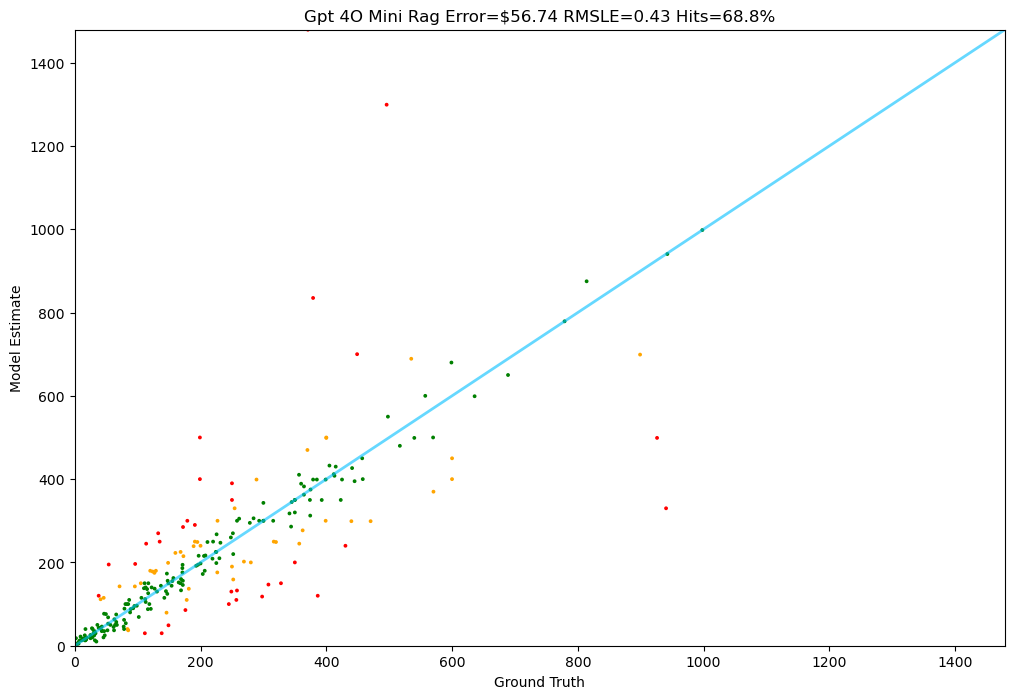

In [45]:
Tester.test(gpt_4o_mini_rag, test)